In [1]:
import yfinance as yf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

plt.style.use('bmh')

In [2]:
tickers = ['AAPL', 'INTC', 'IBM', 'MSFT']
data = yf.download(tickers, period='5y', interval='1d', auto_adjust=True)
data.Close

[*********************100%***********************]  4 of 4 completed


,AAPL,IBM,INTC,MSFT
Date,,,,
2017-02-27,32.320957,135.802719,32.122059,59.957729
2017-02-28,32.335110,136.120636,31.849321,59.724358
2017-03-01,32.996025,137.733017,31.611776,60.620522
2017-03-02,32.800121,136.658096,31.594185,59.752365
2017-03-03,32.993660,136.294739,31.585388,59.976402
...,...,...,...,...
2022-02-18,167.300003,124.349998,45.040001,287.929993
2022-02-22,164.320007,123.919998,44.689999,287.720001
2022-02-23,160.070007,122.070000,44.650002,280.269989


In [3]:
returns = np.log(data.Close/data.Close.shift(1)).dropna()
returns

,AAPL,IBM,INTC,MSFT
Date,,,,
2017-02-28,0.000438,0.002338,-0.008527,-0.003900
2017-03-01,0.020233,0.011776,-0.007486,0.014894
2017-03-02,-0.005955,-0.007835,-0.000557,-0.014425
2017-03-03,0.005883,-0.002662,-0.000278,0.003742
2017-03-06,-0.003153,0.002330,-0.009235,0.000311
...,...,...,...,...
2022-02-18,-0.009400,-0.004974,-0.054651,-0.009678
2022-02-22,-0.017973,-0.003464,-0.007801,-0.000730
2022-02-23,-0.026205,-0.015042,-0.000895,-0.026234


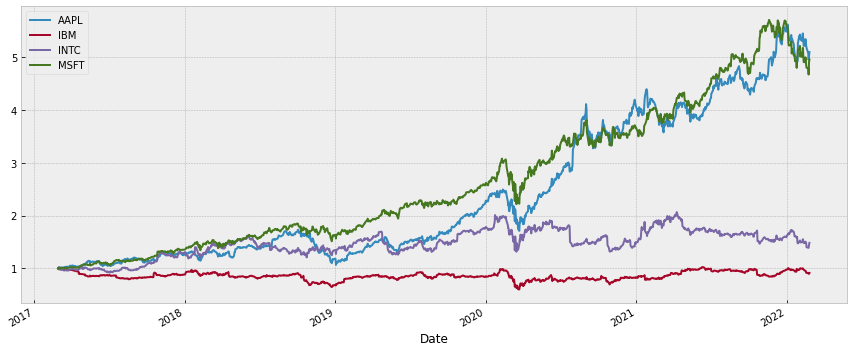

In [4]:
returns.cumsum().apply(np.exp).plot(figsize=(12,5))
plt.tight_layout()
plt.show()

In [5]:
num_portfolios = 100_000
num_days = 252
avg_returns = returns.mean() * num_days
cov_mat = returns.cov() * num_days

In [6]:
weights = np.random.random(size = (num_portfolios, len(tickers)))
sum_weights = weights.sum(axis=1).reshape(-1, 1)
weights = weights/sum_weights

In [7]:
portfolio_returns = np.dot(weights, avg_returns)

portfolio_volatility = np.zeros(shape=(num_portfolios,))
for i in range(len(weights)):
    variance = np.dot(weights[i].T, np.dot(cov_mat, weights[i]))
    stdev = np.sqrt(variance) 
    portfolio_volatility[i] = stdev
    
portfolio_sharpe = portfolio_returns / portfolio_volatility

In [8]:
portfolio_stats = pd.DataFrame(data={'returns':portfolio_returns,
                                     'volatility':portfolio_volatility,
                                     'SharpeRatio':portfolio_sharpe})
portfolio_stats

,returns,volatility,SharpeRatio
0,0.170605,0.246817,0.691219
1,0.146594,0.238968,0.613446
2,0.202373,0.252529,0.801383
3,0.194740,0.239249,0.813963
4,0.141348,0.243697,0.580014
...,...,...,...
99995,0.200843,0.253214,0.793176
99996,0.178951,0.237696,0.752857
99997,0.144800,0.238658,0.606727
99998,0.214762,0.240602,0.892604


In [9]:
sample_returns = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
efficient_returns = []
efficient_volatility = []

for ret in tqdm(sample_returns, leave=False):
    close_indices = np.where(np.isclose(ret, portfolio_returns, atol=1e-3))[0]
    if close_indices.sum() == 0: continue
    min_vol = portfolio_volatility[close_indices].min()
    
    efficient_returns.append(ret)
    efficient_volatility.append(min_vol)

  0%|          | 0/1000 [00:00<?, ?it/s]

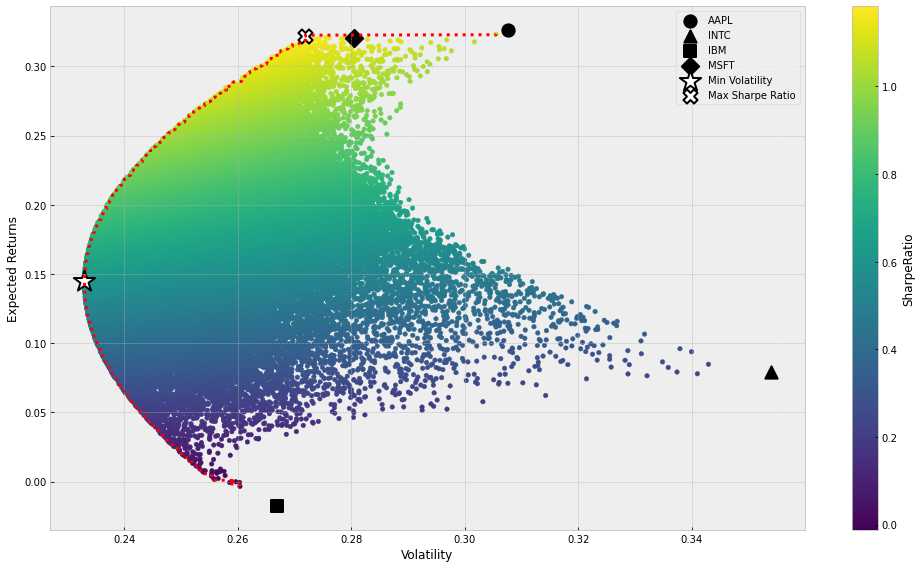

In [10]:
fig, ax = plt.subplots(figsize=(14,8))

portfolio_stats.plot(kind='scatter', x='volatility', y='returns', c='SharpeRatio', 
                     ax=ax, cmap='viridis')
ax.plot(efficient_volatility, efficient_returns, linestyle=':', linewidth=3, color='red')
ax.set_xlabel('Volatility')
ax.set_ylabel('Expected Returns')

markers = ['o', '^', 's', 'D']
for i, ticker in enumerate(tickers):
    ret = avg_returns[ticker]
    vol = np.sqrt(cov_mat.loc[ticker, ticker])
    ax.scatter(vol, ret, marker=markers[i], s=150, linewidths=2,
               edgecolor='black', c='black', label=ticker)
    
min_idx = np.argmin(portfolio_volatility)
ax.scatter(portfolio_volatility[min_idx], portfolio_returns[min_idx],
           marker='*', s=500, linewidths=2, edgecolor='black', c='white', 
           label="Min Volatility")

sharpe_idx = np.argmax(portfolio_sharpe)
ax.scatter(portfolio_volatility[sharpe_idx], portfolio_returns[sharpe_idx],
           marker='X', s=200, linewidths=2, edgecolor='black', c='white', 
           label="Max Sharpe Ratio")
 
ax.legend()
    
plt.tight_layout()
plt.show()

In [11]:
print('-'*50)
print('***** Minimum Volatility Portfolio *****')
print('-'*50)
print('Weights')
for ticker, weight in zip(tickers, weights[min_idx]):
    print(f'{ticker}:{weight*100:.2f}%', end='  ')
print('')
print('Performance')
for stat, val in portfolio_stats.iloc[min_idx, :].items():
    print(f'{stat}:{val*100:.2f}%', end='  ')
    
print('\n\n')

print('-'*50)
print('***** Maximum Sharpe Ratio Portfolio *****')
print('-'*50)
print('Weights')
for ticker, weight in zip(tickers, weights[sharpe_idx]):
    print(f'{ticker}:{weight*100:.2f}%', end='  ')
print('')
print('Performance')
for stat, val in portfolio_stats.iloc[sharpe_idx, :].items():
    print(f'{stat}:{val*100:.2f}%', end='  ')

--------------------------------------------------
***** Minimum Volatility Portfolio *****
--------------------------------------------------
Weights
AAPL:15.62%  INTC:50.75%  IBM:2.05%  MSFT:31.59%  
Performance
returns:14.47%  volatility:23.30%  SharpeRatio:62.11%  


--------------------------------------------------
***** Maximum Sharpe Ratio Portfolio *****
--------------------------------------------------
Weights
AAPL:33.74%  INTC:0.08%  IBM:0.19%  MSFT:65.98%  
Performance
returns:32.16%  volatility:27.19%  SharpeRatio:118.28%  